# **Heart Failure Risk Analysis**

## Introduction

**Background:** Heart failure occurs when the heart muscle doesn’t pump blood around the body correctly. This failure of the heart stems from a multitude of factors, such as high blood pressure or narrowed arteries. Heart failure is a condition of Cardiovascular disease (CVD), a disease that is the number 1 cause of death globally, taking ~17.9 million lives yearly. Heart failure affects everyone in some form, meaning it is vital that those who are at risk of heart failure know as soon as possible.

**Question:** How accurate is our model in predicting whether a person suffering from heart failure dies on the basis of the variables used in our dataset?

**Dataset:** The dataset can be found here: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data. It includes 13 columns of data, 6 of which are binary. The binary data includes information regarding the patients wellbeing (e.g smoking). Meanwhile, the other quantitative data include information about the body of the patient (e.g. enzyme levels).

We want to be able to use this data and apply a knn model to determine the likeliness of a death event to the patient based on their health level. Patients age range is 40-95 years.

---

## Methods & Results

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

* Data has been imported from a public Github respository. Our first stage of analysis starts with converting death_event into a factor since it is our target variable. 
* Simultaneously, we have renamed our column names to improve user readability.

In [3]:
set.seed(69420)
#import the data from the web and convert DEATH_EVENT to a factor for future predictive modelling
heart_data_raw <- read_csv("https://raw.githubusercontent.com/SaadRehmanCS/DSCI_project/master/heart_failure_clinical_records_dataset.csv") %>%
                mutate(DEATH_EVENT = as_factor(DEATH_EVENT))

#rename column variables to improve user-readability         
colnames(heart_data_raw) <- c("patient_age","anaemia","cpk_enzyme_level", "diabetes",
                              "blood_pump_fraction", "high_blood_pressure", "platelets_level", "creatinine_level",
                              "sodium_level", "sex", "smoker", "time_of_failure", "death_event")
head(heart_data_raw)

Parsed with column specification:
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)



patient_age,anaemia,cpk_enzyme_level,diabetes,blood_pump_fraction,high_blood_pressure,platelets_level,creatinine_level,sodium_level,sex,smoker,time_of_failure,death_event
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
50,1,111,0,20,0,210000,1.9,137,1,0,7,1
65,1,160,1,20,0,327000,2.7,116,0,0,8,1
90,1,47,0,40,1,204000,2.1,132,1,1,8,1


* We only want this analysis to focus on patients who have previous history with suffering from diabetes or high blood pressure. So we have removed any patients who do not fall under this category.

In [4]:
#pivot the anaemia, diabetes, high_blood_pressure columns into a single column, and then remove patients with anaemia, or without any condition
heart_data_condition <- heart_data_raw %>%
                pivot_longer(cols=c(anaemia, diabetes, high_blood_pressure), names_to="medical_condition", values_to="patient_has_it") %>%
                filter(patient_has_it == 1, medical_condition != "anaemia")

* From the very beginning, we have decided to remove a few columns that we feel wont provide us with any meaningful conclusions from our particular analysis.
* Additionally, we have removed all cpk_enzyme_level values that cross the range of 1500. This is solely because there are very rare instances of this happening, and they lead to an unreasonably scaled axis when plotted on a visualisation. Removing them will give a more accurate and easy to read depiction of this column.

In [5]:
#remove columns that we are un-interested in, and only keep those we will actually use. Also remove abnormally high values of cpk_enzyme
heart_data <- heart_data_condition %>%
            select(-patient_has_it, -medical_condition, -time_of_failure, -sex, -smoker) %>%
            filter(cpk_enzyme_level < 1500)



* We have split the data into training and testing sets in a 3:1 ratio respectively. The testing set will be locked away until we need it to test the accuracy of our chosen K value. The training set will be used to train, cross validate, and tune our knn-model.

In [6]:
#split the data 
heart_data_split <- initial_split(heart_data, prop = 0.75, strata = death_event)
#declare the training set
heart_data_train <- training(heart_data_split)
#declare the test set
heart_data_test <- testing(heart_data_split)

head(heart_data_train)


patient_age,cpk_enzyme_level,blood_pump_fraction,platelets_level,creatinine_level,sodium_level,death_event
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
60,315,60,454000,1.1,131,1
80,123,35,388000,9.4,133,1
75,81,38,368000,4.0,131,1
49,80,30,427000,1.0,138,0
70,125,25,237000,1.0,140,1
48,582,55,87000,1.9,121,1


* We would like to determine which variables have the greatest influence on death_event, and only use those variables in our actual knn model. We will do this by plotting facetted boxplots.
* The variable names have been given more human-readable names for plotting purposes.
* All predictor variables have been pivotted into a single column.

In [7]:
#declare plot axes labels
# source:
# https://stackoverflow.com/questions/3472980/how-to-change-facet-labels
variable_names <- c(patient_age = "Patient age (Year)",
                    cpk_enzyme_level = "CPK enzyme level (mcg/L)",
                    blood_pump_fraction = "Pumped blood (percentage)",
                    platelets_level = "Platelets (kiloplatelets/mL)",
                    creatinine_level = "Creatinine level (mg/dL))",
                    sodium_level = "Sodium level (mEq/L)")

#pivot all columns from patient_age to sodium_level into one column named variable
pivoted_heart_data <- heart_data_train %>% 
                    pivot_longer(cols=c(patient_age:sodium_level), names_to="variable", values_to="value") 



* This plot will create facetted boxplots for each predictor variable, used to discover relationships in each predictor for those that have survived, against those that have died.

In [8]:
#create facetted boxplots for each predictive variable
# source: 
# https://stackoverflow.com/questions/14604439/plot-multiple-boxplot-in-one-graph
heart_data_boxplot <- pivoted_heart_data %>% # all variables are merged in two columns one for the names and the other for values
                    ggplot(aes(x=variable, y=value)) +
                    geom_boxplot(aes(fill=death_event)) + 
                    facet_wrap( ~ variable, scales="free", labeller = as_labeller(variable_names))+    # boxplot theme based on death_event
                    labs(x = "Variable", y = "Value") +
                    scale_fill_discrete(name = "Death Event", labels = c("Survived", "Died")) +         # legend name and values name
                    theme(text = element_text(size=20), axis.text.x = element_blank())                 # text size

# source:
# https://stackoverflow.com/questions/3261597/can-i-change-the-position-of-the-strip-label-in-ggplot-from-the-top-to-the-botto
# facet_wrap( ~ variable, scales="free", labeller = as_labeller(variable_names), strip.position="bottom") in case we want to change
#the position of the facet labels

* We can see from the plots that cpk_enzyme_level and platelets_level dont have very distinct measures of center and spread when comparing surviving vs death values. Therefore, they will not serve useful in creating our predictive model and can thus be discarded.

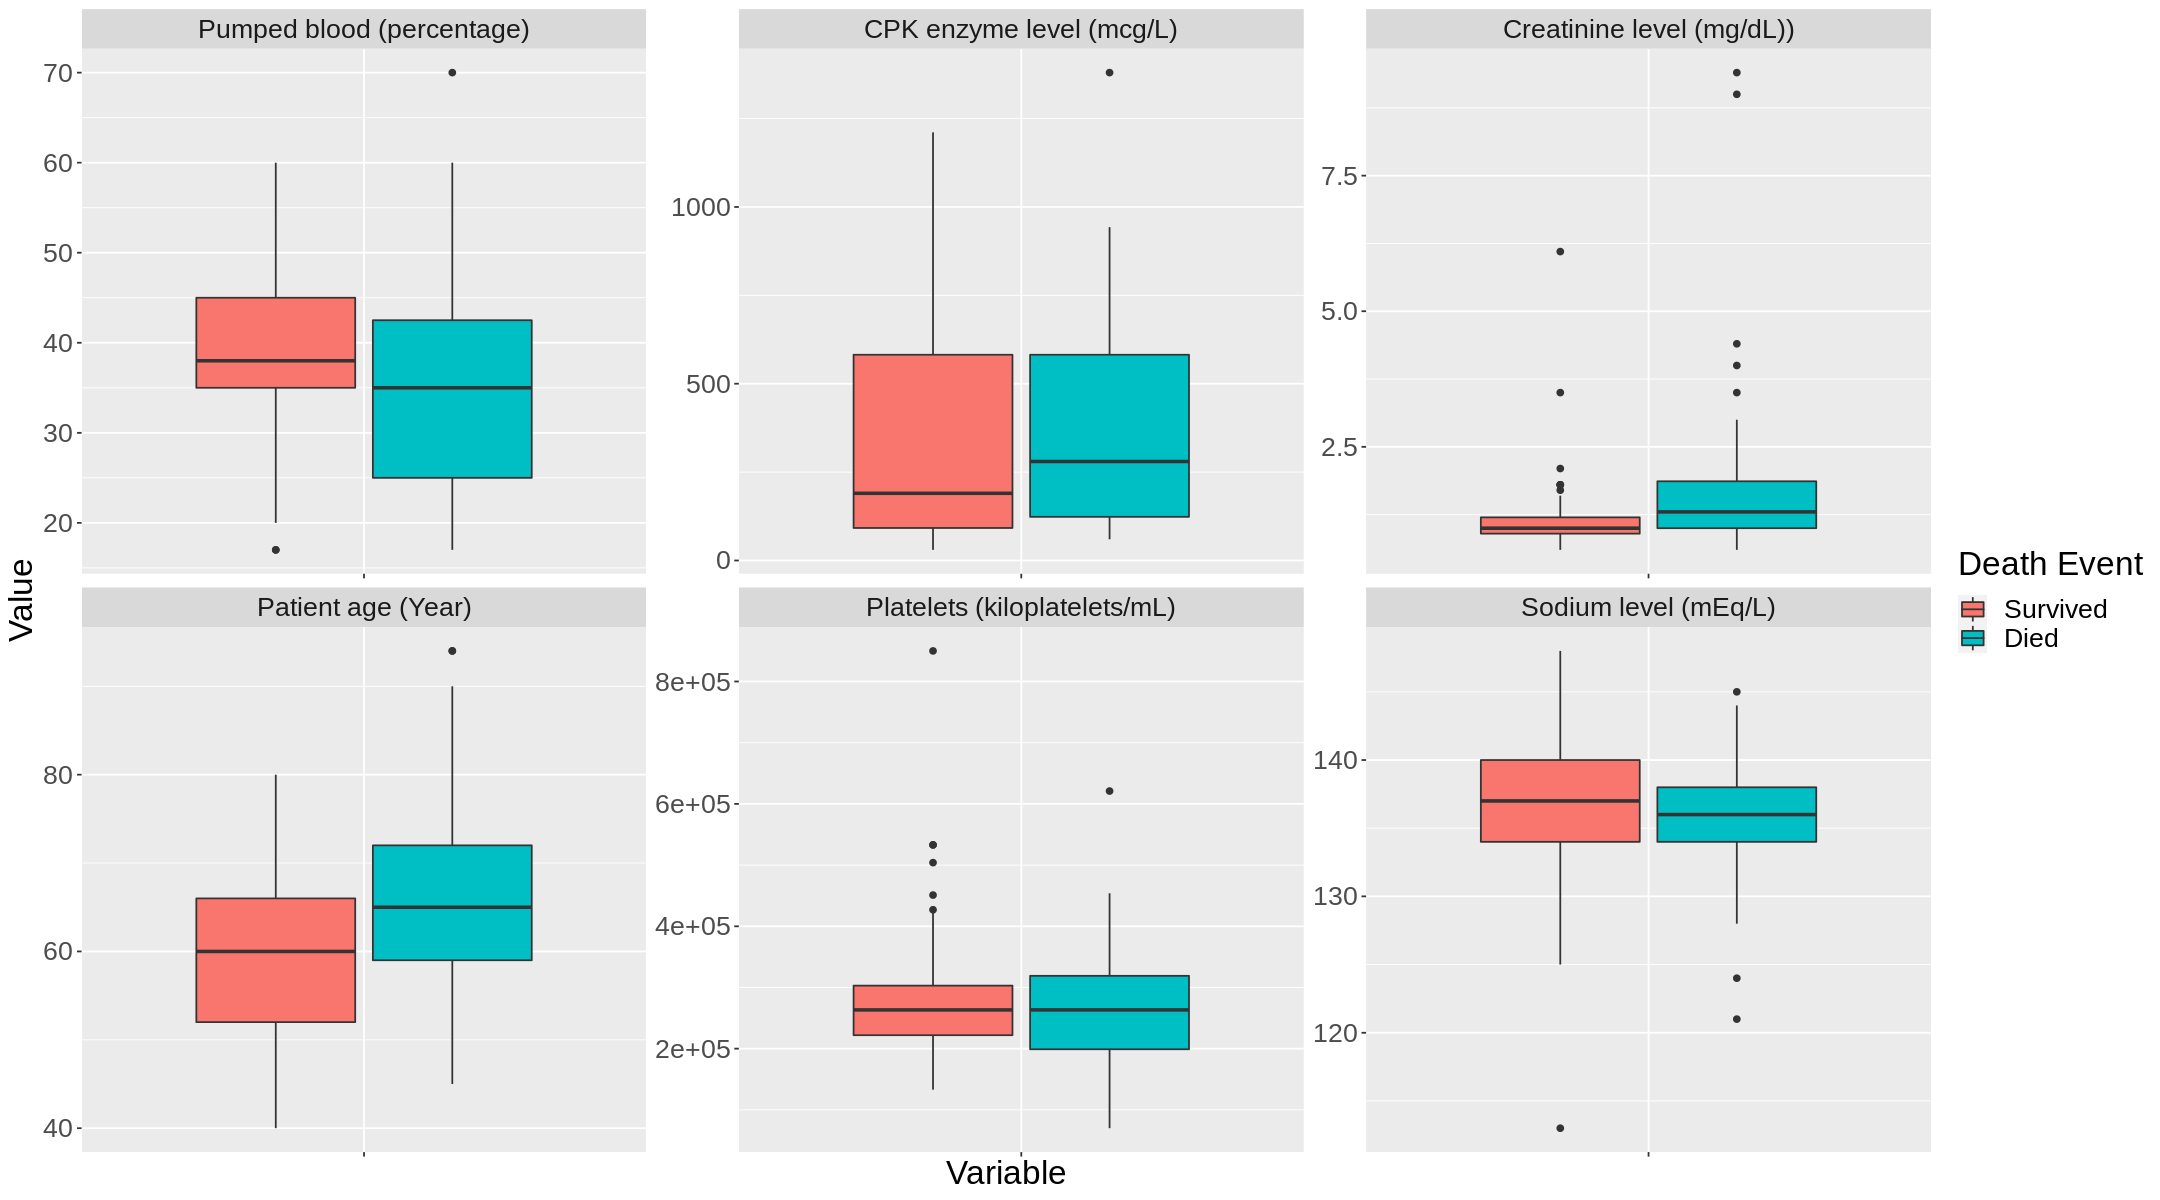

In [9]:
options(repr.plot.width = 18, repr.plot.height = 10)   # resize the shape
#plot the visualization
heart_data_boxplot

options(repr.plot.width = NULL, repr.plot.height = NULL) 

# TODO
## BRIEF EXPLANATION OF THE SELECTED VARIABLES, SO READERS CAN UNDERSTAND EXACTLY WHAT WE ARE ANALYSING. PREFERABLY BULLET POINTS FOR EACH

The variables used in this data set are : 
- **Age** - As people age the increased stiffness in the large arteries can lead to hypertension and possibly heart failure. (National Institute on Aging (2018))

- **Anaemia** (Decrease of red blood cells or hemoglobin; 1 or 0)

- **Creatinine Phosphokinase** (Level of the CPK enzyme in the blood)

- **Diabetes** (If the patient diabetes or not; 1 or 0)

- **Ejection Fraction** (Percentage of blood leaving the heart at each contraction) - A ejection fraction measurement under 40 percent may be evidence of heart failure. (American Heart Association (2017))

- **High Blood Pressure** (If the patient has high blood pressure or not; 1 or 0)

- **Platelets** (Amount of platelets present in the blood)

- **Serum Creatinine** (Level of serum creatinine in the blood) - Elevated serum creatinine has been associated with increased mortality in hypertensive persons and the elderly (Wannamethee, S.G., Shaper, A.G. and Perry, I.J. (1997))

- **Serum Sodium** (Level of serum sodium in the blood) - patients with normal sodium levels had a higher chance of survival over patients with a serum sodium concentration of <135 mEq/L. (Gebresillassie, B.M. and Abegaz, T.M. (2018))

- **Sex** (Male or female)

- **Smoking** (Whether the patient smokes or not; 1 or 0)

## POSSIBLY USE THIS PART TO INCLUDE CITATIONS (citations added?)

* Summarized data for our chosen predictor variables; it shows us the minimum, maximum, mean values, and ensures that we dont have any NA values in our dataframe.

In [10]:
#group the data by the variable name, and summarize min, max, mean, anyNA accordingly. Filter out redundant variables
summarized_heart_data <- pivoted_heart_data %>%
                        group_by(variable) %>%
                        summarize(min = min(value), max = max(value), mean = mean(value))  %>% 
                        mutate(anyNA = anyNA(variable)) %>%
                        filter(variable != "cpk_enzyme_level", variable != "platelets_level")
summarized_heart_data

`summarise()` ungrouping output (override with `.groups` argument)



variable,min,max,mean,anyNA
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
blood_pump_fraction,17.0,70.0,38.531250,FALSE
creatinine_level,0.6,9.4,1.380562,FALSE
patient_age,40.0,94.0,61.677087,FALSE
sodium_level,113.0,148.0,136.193750,FALSE


* Creating a vector to store the number of people who survived, versus those who died.

In [11]:
#select out the dead_event column
death_event_column <- heart_data_train %>% select(death_event)

#create a vector to store the number of values for each of death_event == 0 and 1
number_of_people <- c(death_event_column %>% 
                      filter(death_event == 0) %>% 
                      nrow(), death_event_column %>% 
                      filter(death_event == 1) %>% 
                      nrow())
#create vector with column names
death_event <- c("survived", "died")

#create a data frame
df <- data.frame(death_event, number_of_people) 

* Here we have created a bar plot visualisation of the number of people who died, against those who survived.
* We can see that almost twice as many people survived compared to those who had died.

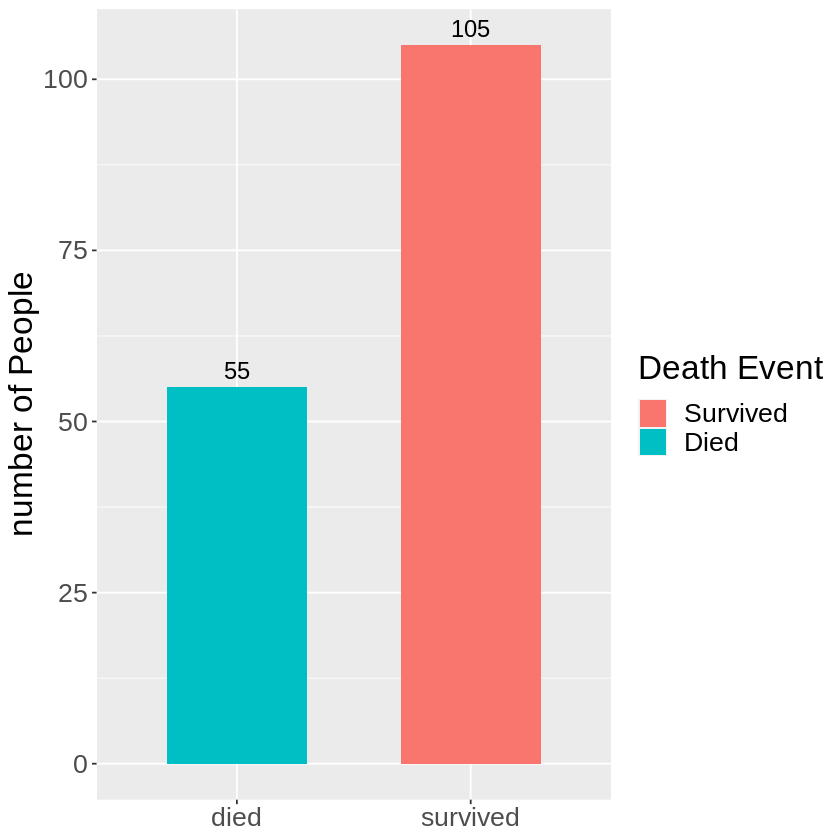

In [12]:
#create a barplot, with bars filled in by death_event. 
death_event_summary_plot <- ggplot(df, aes(x=death_event, y=number_of_people, fill = death_event)) +
                            geom_bar(stat="identity", width = 0.6) +
                            labs(x = NULL, y = "number of People")  +
                            scale_fill_manual(values = c("#00bfc4", "#f8766d"), name = "Death Event", labels = c("Died", "Survived")) +
                            theme(text = element_text(size = 20)) +
                            geom_text(aes(label=number_of_people), vjust=-0.5, size=5) +
                            guides(fill = guide_legend(reverse = TRUE))
       
death_event_summary_plot

* The training dataset has removed the redundant columns that we will not be continuing with.

In [13]:
#select only the relevent columns from the training set
heart_data_train <- select(heart_data_train, patient_age, blood_pump_fraction, creatinine_level:death_event)
#select only the relevent columns from the training set
heart_data_test <- select(heart_data_test, patient_age, blood_pump_fraction, creatinine_level:death_event)

* A recipe has been created using the training set, where we have standardized the data by scaling and centering every point

In [14]:
#create recipe and standardize data
heart_data_recipe <- recipe(death_event ~ ., data = heart_data_train) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors()) 

* From the above summary plot, we can see that we have more observations for people that survived than those who died. This might introduce a bias towards one category of patients, so we have balanced the training dataset

In [15]:
#data balancing of the training data with prep and bake to get a readable dataframe
heart_data_train_scaled <- heart_data_recipe %>%
                    step_upsample(death_event, over_ratio = 1, skip = FALSE) %>%
                    prep() %>%
                    bake(heart_data_train)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [16]:
#cross-validation split
heart_data_vfold <- vfold_cv(heart_data_train_scaled, v = 5, strata = death_event)
#tibble to store 10 different values for the neighbors(k)
gridvals <- tibble(neighbors = seq(1:10))

In [17]:
#create knn classification model with tune() to collect different measurements of k
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

In [18]:
#workflow with recipe and model, run tune_grid and collect_metrics to get the mean for each value of k
knn_fit <- workflow() %>%
         add_recipe(heart_data_recipe) %>%
         add_model(knn_spec) %>%
         tune_grid(resamples = heart_data_vfold, grid = gridvals) %>%
         collect_metrics()

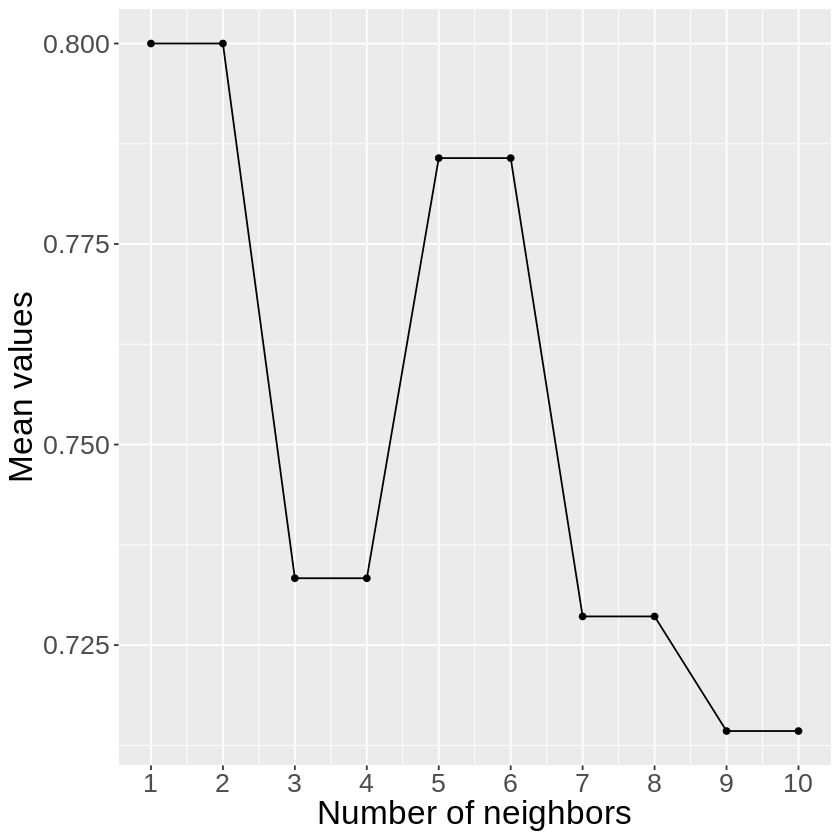

In [24]:
#filter the df to only include accuracy in the .metrics column
knn_fit <- knn_fit %>%
            filter(.metric == "accuracy")
#plot the summary of means to make it visually easier to pick a neighbor value
knn_fit_plot <-  knn_fit %>%
            ggplot(aes(x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            labs(x = "Number of neighbors", y = "Mean values") +
            theme(text = element_text(size = 20)) +
            scale_x_continuous(breaks = seq(0, 10, by = 1))  # adjusting the x-axis
knn_fit_plot

# INCLUDE WHY WE CHOSE K 
## We have chosen our value to be k = 1
We chose the k-value of 1 as it had the highest accuracy estimate in the cross-validation plot (alongside a k-value of 2). Cross-validation is used to determine the optimum k-value for maximum accuracy.

In [93]:
#our chosen value of k
chosen_k = 1
#re-create the model, this time with a specific value of k
knn_spec_test <- nearest_neighbor(weight_func = "rectangular", neighbors = chosen_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

In [94]:
#re-create the workflow, this time with the new model, and with the fit() function instead of tune_grid()
knn_fit_test <- workflow() %>%
            add_recipe(heart_data_recipe) %>%
            add_model(knn_spec_test) %>%
            fit(data = heart_data_train)

In [98]:
#predict the values of the testing set using the new trained model
heart_data_predict <- knn_fit_test %>%
            predict(heart_data_test) %>%
            bind_cols(heart_data_test) 

In [100]:
#run metrics to get the accuracy of the predictions
heart_data_accuracy <- heart_data_predict %>%
                metrics(truth = death_event, estimate = .pred_class)
heart_data_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7169811
kap,binary,0.4373673


In [102]:
#run conf_mat to get the matrix of correct/wrong predictions
heart_data_mat <- heart_data_predict %>%
            conf_mat(truth = death_event, estimate = .pred_class)
heart_data_mat

          Truth
Prediction  0  1
         0 23  3
         1 12 15

# TO-DO    
## METHODS WILL BE EXPLAINED HERE AT THE VERY END OF ANALYSIS, BEFORE DISCUSSION. IT MUST BE ATLEAST ONE PARAGRAPH LONG, OR CONTAIN BULLET POINTS

The methods used in this report are repetitve and coherent. 

*Step 1* - Import data from GitHub repository to the Jupiter notebook and convert death_event into a factor since that is our target variable.

*Step 2* - Filter out patients who have previous history with suffering from diabetes and anaemia 

*Step 3* - Remove all cpk_enzyme_level values that are above 1500. This is done to eliminate outliers as the certainty of this happening is extremely low and including them in the data will lead to an unreasonably scaled axis in a visualisation.

*Step 4* - Split the data into testing and training data with testing being 75% and training being 25%.

*Step 5* - Create a facetted box plot to determine which variables have the greatest influence on death event

*Step 6* - From the facetted box plot, it can be concluded which variables have the least influence and thus they can be discarded. In our case it was cpk_enzyme_levels and platelets_levels.

*Step 7* - Summarise the data so that it clearly shows the mean, max and min values and ensure that there is no NA present in the data set

*Step 8* - Create a vector to store the number of people who have died vs those who survived

*Step 9* - Plot the above vector in the form of a bar plot.

*Step 10* - Select relevant columns from the data set and then create a recipe with standardised data

## REMEMBER TO ASK TA ABOUT WHERE TO PLACE THE VISUALISATION WE FAILED TO IMPLEMENT IN PHASE 1

---

## Discussion

**Summary of Findings:** Our model has an accuracy of 71.70%, meaning that our model is fairly accurate but could still use further tuning. This means that we have a ~70% chance to accurately predict whether the patient will die from heart failure when given the key selected variables.

**Were the Findings what we expected?:** We expected to find that a higher age and creatinine level, as well as a lower blood pump fraction and sodium level, would lead to higher risk of death by heart failure.

**Impact of Findings:** If we can train our model to determine the risk of someone dying from heart failure, we can provide early warnings to people who are most at risk. This warning system could potentially save many lives, as the chance of survival drastically decreases when medical issues are left undetected.

**Future Questions:** In the future, we can potentially use the data to train a bot that regular people could use to get a better understanding of their own standing in regards to heart failure vulnerability. Additionally, this model could then be used in conjunction with other models for various health issues.

---

## References

kaggle.com. (n.d.). Heart Failure Prediction. [online] Available at: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data.

Abebe, T.B., Gebreyohannes, E.A., Tefera, Y.G., Bhagavathula, A.S., Erku, D.A., Belachew, S.A., Gebresillassie, B.M. and Abegaz, T.M. (2018). The prognosis of heart failure patients: Does sodium level play a significant role? PLoS ONE, [online] 13(11). Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6224129/



American Heart Association (2017). Ejection Fraction Heart Failure Measurement. [online] www.heart.org. Available at: https://www.heart.org/en/health-topics/heart-failure/diagnosing-heart-failure/ejection-fraction-heart-failure-measurement.

Wannamethee, S.G., Shaper, A.G. and Perry, I.J. (1997). Serum Creatinine Concentration and Risk of Cardiovascular Disease. Stroke, 28(3), pp.557–563.

National Institute on Aging (2018). Heart Health and Aging. [online] National Institute on Aging. Available at: https://www.nia.nih.gov/health/heart-health-and-aging.

Bhf.org.uk. (2019). Heart failure. [online] Available at: https://www.bhf.org.uk/informationsupport/conditions/heart-failure.